Hello Team XXTX !

Let's first use cubic splines to get the 3D track geometry $(x(s),y(s),z(s))$ from waypoint coordinates: 

1685685910.793043


C:\Users\USER\AppData\Local\Temp\ipykernel_18120\796786421.py:143: RuntimeWarning: invalid value encountered in sqrt
  hSphereCentre = np.sqrt( r**2 - (bTrack[i]/2)**2  )


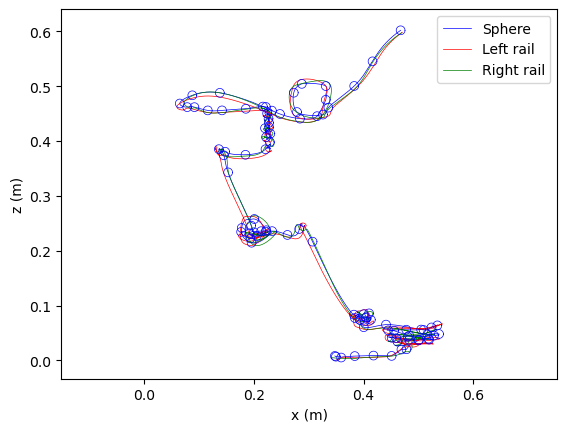

Elevation profile of the track


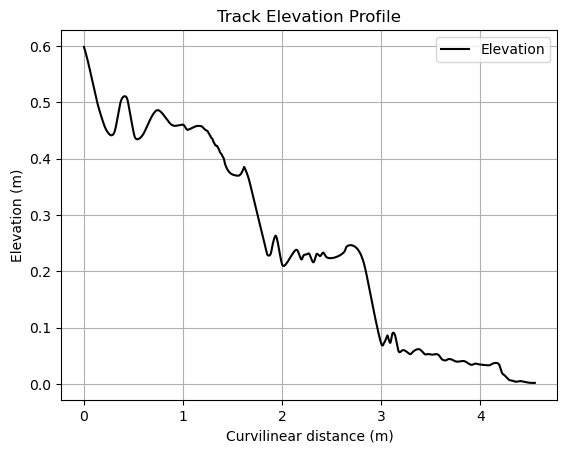

Curvature profile


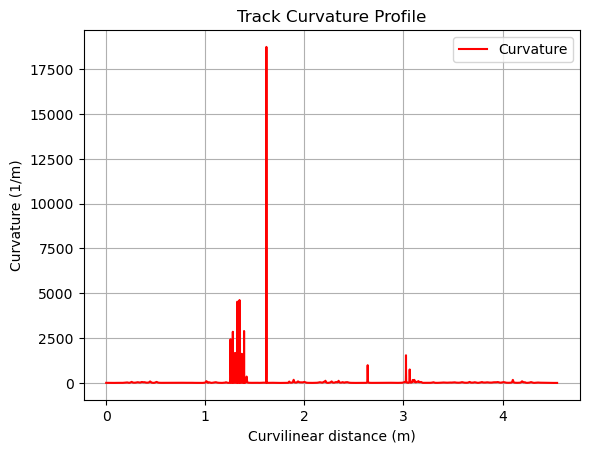

Track width profile


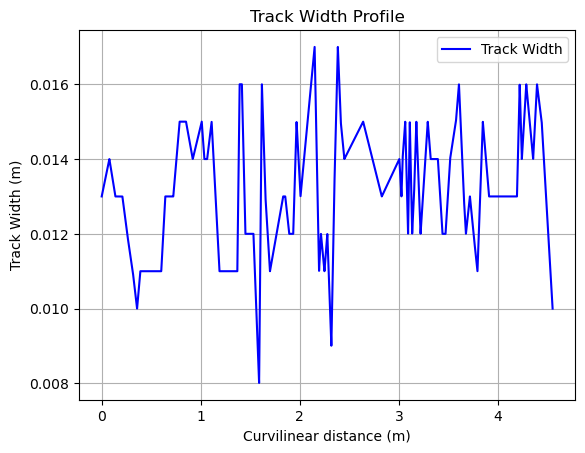

Average track width: 0.01 m
Show track geometry and spheres at waypoints (2D view)


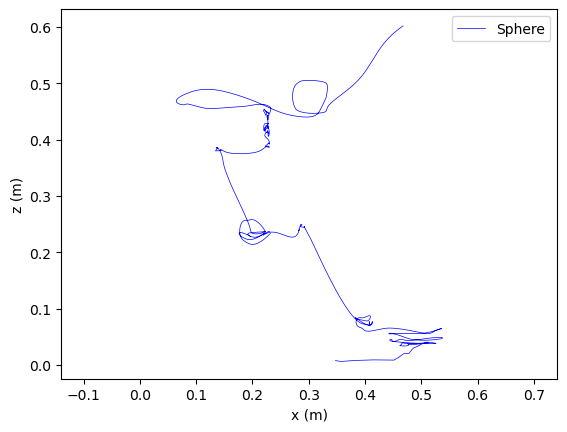

Show track geometry and spheres at waypoints (3D view)


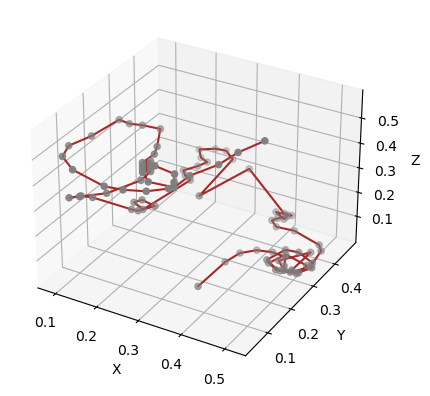

Execution time: 7.0732715129852295 seconds


In [1]:
import time
import os
import numpy as np
import scipy.interpolate as spip
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

start_time = time.time()
print(start_time)

# Choose the case you want to run:
tag = 'Own' # choose between 'Loop', 'Turn', 'STA1', and 'Own'

# Define or load waypoint coordinates (cm), track width (cm), track tilt (deg) and isUpsideDown data:
if tag == 'Loop':
    # 3D geometry data for a clothoid curve:
    xWaypoints = [-18.70, -9.62, -0.83, 6.29, 8.83, 4.32, -4.32, -8.83,	-6.29, 0.83, 9.62, 18.70]
    yWaypoints = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    zWaypoints = [0, 0.31, 2.49, 7.98, 16.50, 24.02, 24.02, 16.50, 7.98, 2.49, 0.31, 0]
    bWaypoints = 1.3*np.ones(12) # track width
    ThetadWaypoints = 0*np.ones(12) # tilt angle
    isUpsideDownWaypoints = [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0]
    xyzWaypoints = np.row_stack((xWaypoints, yWaypoints, zWaypoints)) 
elif tag == 'Turn':
    # 3D geometry data for a horizontal turn: 
    xWaypoints = [0, 6.18, 11.76, 16.18, 19.02, 20, 19.02, 16.18, 11.76, 6.18, 0]
    yWaypoints = [-20, -19.02, -16.18, -11.76, -6.18, 0, 6.18, 11.76, 16.18, 19.02, 20]
    zWaypoints = 0*np.ones(11)
    bWaypoints = 1.3*np.ones(11) # track width
    ThetadWaypoints = -20*np.ones(11) # tilt angle
    isUpsideDownWaypoints = 0*np.ones(11)
    xyzWaypoints = np.row_stack((xWaypoints, yWaypoints, zWaypoints)) 
elif tag == 'STA1':
    # 3D geometry data for STA track no. 1 (for comparison tests):
    dataWaypoints = np.loadtxt('trackGeometrySTA1.csv', delimiter=',')
    xWaypoints = dataWaypoints[:,1]
    yWaypoints = dataWaypoints[:,2]
    zWaypoints = dataWaypoints[:,3]
    bWaypoints = dataWaypoints[:,4]
    ThetadWaypoints = dataWaypoints[:,5]
    isUpsideDownWaypoints = dataWaypoints[:,6]
    xyzWaypoints = np.row_stack((xWaypoints, yWaypoints, zWaypoints))
elif tag == 'Own':
    # 3D geometry data for your own track:
    dataWaypoints = np.loadtxt('trackGeometry3AT4.csv', delimiter=',')
    xWaypoints = dataWaypoints[:,1]
    yWaypoints = dataWaypoints[:,2]
    zWaypoints = dataWaypoints[:,3]
    bWaypoints = dataWaypoints[:,4]
    ThetadWaypoints = dataWaypoints[:,5]
    isUpsideDownWaypoints = dataWaypoints[:,6]
    xyzWaypoints = np.row_stack((xWaypoints, yWaypoints, zWaypoints))

# Convert units to meters (m):
xyzWaypoints = xyzWaypoints/100
bWaypoints = bWaypoints/100

# Calculate interpolation coordinate following Lee (1989):
deltaSigma = np.sqrt(np.sum(np.diff(xyzWaypoints)**2, axis=0))
sigmaWaypoints = np.hstack(((0), np.cumsum(np.sqrt(deltaSigma))))
sigmaEnd = sigmaWaypoints[-1]

# Interpolate using cubic splines: 
spline = spip.splprep(xyzWaypoints, u=sigmaWaypoints, s=0)[0]
    
# Sample path at equal intervals:
numTrackpoints = 10000;
sigmaTrack = np.linspace(0, sigmaEnd, numTrackpoints)
xyzTrack = np.array(spip.splev(sigmaTrack, spline))
    
# Integrate to obtain curvilinear distance:
ds = np.sqrt(np.sum(np.diff(xyzTrack)**2, axis=0))
sTrack = np.hstack(((0), np.cumsum(ds)))
    
# Differentiate to get tangent and curvature vectors: 
TxTyTzTrack = np.gradient(xyzTrack, sTrack, axis=1, edge_order=2)
KxKyKzTrack = np.gradient(TxTyTzTrack, sTrack, axis=1, edge_order=2)
    
# Interpolate to get curvilinear distance at waypoints:
sWaypoints = np.interp(sigmaWaypoints,sigmaTrack,sTrack)

# Interpolate to get the tangent and curvature vectors at the waypoints:
TxTyTzWaypoints = np.array([np.interp(sWaypoints, sTrack, Td) for Td in TxTyTzTrack])
KxKyKzWaypoints = np.array([np.interp(sWaypoints, sTrack, Kd) for Kd in KxKyKzTrack])

# Find the normal and binormal vectors at the waypoints:
numWaypoints = len(ThetadWaypoints)
Zhat = np.array([0,0,1]) # unit vertical vector
NxNyNzWaypoints = np.zeros((3, numWaypoints))
BxByBzWaypoints = np.zeros((3, numWaypoints))
for i in range(numWaypoints):
    T = TxTyTzWaypoints[:,i] # tangent vector
    That = T/np.linalg.norm(T) # unit tangent vector
    Thetad = ThetadWaypoints[i] # tilt angle (deg)
    Theta = Thetad*np.pi/180 # tilt angle (rad)
    # Find zero-tilt track normal N0hat using Gram-Schmidt:
    N0 = Zhat - np.dot(Zhat,That)*That
    N0hat = N0/np.linalg.norm(N0)
    # Find zero-tilt track binormal B0hat using cross product:
    B0hat = np.cross(N0hat, That);
#-------------------------------------------------------------------------------------------------------------------------------
    # Find rotation angle around axis That:
    Phi = np.arctan( np.tan(Theta)/np.dot(N0hat,Zhat))
    '''Phi = np.arcsin( np.sin(Theta)/np.dot(N0hat,Zhat))'''
#-------------------------------------------------------------------------------------------------------------------------------
    # Obtain track binormal Bhat by rotation around axis That:
    Bhat = np.cos(Phi)*B0hat + np.sin(Phi)*N0hat
    # Obtain track normal Nhat using cross product:
    Nhat = np.cross(That, Bhat)
    # Put into arrays:
    if isUpsideDownWaypoints[i] == 1:
        BxByBzWaypoints[:,i] = -Bhat
        NxNyNzWaypoints[:,i] = -Nhat
    else:
        BxByBzWaypoints[:,i] = Bhat
        NxNyNzWaypoints[:,i] = Nhat
    
# Interpolate the track width, normal and binormal vectors:
bTrack = np.interp(sTrack, sWaypoints, bWaypoints)
BxByBzTrack = np.array([np.interp(sTrack, sWaypoints, Bd) for Bd in BxByBzWaypoints])
NxNyNzTrack = np.array([np.interp(sTrack, sWaypoints, Nd) for Nd in NxNyNzWaypoints])    

# Use Gram-Schmidt to insure unit length and orthogonality of the frame vectors:
for i in range(numTrackpoints):
    T = TxTyTzTrack[:,i]
    B = BxByBzTrack[:,i]
    N = NxNyNzTrack[:,i]
    That = T/np.linalg.norm(T)
    Bperp = B - np.dot(B,That)*That
    Bhat = Bperp/np.linalg.norm(Bperp)
    Nperp = N - np.dot(N,That)*That - np.dot(N,Bhat)*Bhat
    Nhat = Nperp/np.linalg.norm(Nperp)
    TxTyTzTrack[:,i] = That
    BxByBzTrack[:,i] = Bhat
    NxNyNzTrack[:,i] = Nhat

# Find the coordinates of the sphere centre, left and right rails:
r = 0.008 # sphere radius (m)
xyzSphereCentre = np.zeros((3, numTrackpoints))
xyzLeftRail = np.zeros((3, numTrackpoints))
xyzRightRail = np.zeros((3, numTrackpoints))
for i in range(numTrackpoints):
    hSphereCentre = np.sqrt( r**2 - (bTrack[i]/2)**2  )
    xyzSphereCentre[:,i] = xyzTrack[:,i] + hSphereCentre*NxNyNzTrack[:,i]
    xyzLeftRail[:,i] = xyzTrack[:,i] + 0.5*bTrack[i]*BxByBzTrack[:,i]
    xyzRightRail[:,i] = xyzTrack[:,i] - 0.5*bTrack[i]*BxByBzTrack[:,i]

# Show track geometry and spheres at waypoints (2D view):
plt.figure()
view = 'xz' # choose between 'xy', 'xz' and 'yz'
if view == 'xy': 
    plt.plot(xyzSphereCentre[0], xyzSphereCentre[1], "b-", label='Sphere', linewidth=0.5)
    plt.plot(xyzLeftRail[0], xyzLeftRail[1], "r-", label='Left rail', linewidth=0.5)
    plt.plot(xyzRightRail[0], xyzRightRail[1], "g-", label='Right rail', linewidth=0.5)
    # Show sphere silhouettes at waypoints:
    for i in range(numWaypoints):
        xyzCentre = np.array([np.interp(sWaypoints[i], sTrack, d) for d in xyzSphereCentre])
        plt.plot(xyzCentre[0]+r*np.cos(np.arange(0,1.01,0.01)*2*np.pi), xyzCentre[1]+r*np.sin(np.arange(0,1.01,0.01)*2*np.pi), "b-", linewidth=0.5)        
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
elif view == 'xz': 
    plt.plot(xyzSphereCentre[0], xyzSphereCentre[2], "b-", label='Sphere', linewidth=0.5)
    plt.plot(xyzLeftRail[0], xyzLeftRail[2], "r-", label='Left rail', linewidth=0.5)
    plt.plot(xyzRightRail[0], xyzRightRail[2], "g-", label='Right rail', linewidth=0.5)
    # Show sphere silhouettes at waypoints:
    for i in range(numWaypoints):
        xyzCentre = np.array([np.interp(sWaypoints[i], sTrack, d) for d in xyzSphereCentre])
        plt.plot(xyzCentre[0]+r*np.cos(np.arange(0,1.01,0.01)*2*np.pi), xyzCentre[2]+r*np.sin(np.arange(0,1.01,0.01)*2*np.pi), "b-", linewidth=0.5)        
    plt.xlabel("x (m)")
    plt.ylabel("z (m)")
elif view == 'yz':
    plt.plot(xyzSphereCentre[1], xyzSphereCentre[2], "b-", label='Sphere', linewidth=0.5)
    plt.plot(xyzLeftRail[1], xyzLeftRail[2], "r-", label='Left rail', linewidth=0.5)
    plt.plot(xyzRightRail[1], xyzRightRail[2], "g-", label='Right rail', linewidth=0.5)
    # Show sphere silhouettes at waypoints:
    for i in range(numWaypoints):
        xyzCentre = np.array([np.interp(sWaypoints[i], sTrack, d) for d in xyzSphereCentre])
        plt.plot(xyzCentre[1]+r*np.cos(np.arange(0,1.01,0.01)*2*np.pi), xyzCentre[2]+r*np.sin(np.arange(0,1.01,0.01)*2*np.pi), "b-", linewidth=0.5)         
    plt.xlabel("y (m)")
    plt.ylabel("z (m)")
plt.axis("equal")
plt.legend()
plt.savefig('trackGeometry.jpg', format='jpg', dpi=1200) # export figure to disk
plt.show()

# Plot the elevation profile of the track
print('Elevation profile of the track')
plt.figure()
plt.plot(sTrack, xyzTrack[2], "k-", label='Elevation')
plt.xlabel("Curvilinear distance (m)")
plt.ylabel("Elevation (m)")
plt.title("Track Elevation Profile")
plt.grid(True)
plt.legend()
plt.show()

# Calculate the curvature
curvature = np.linalg.norm(KxKyKzTrack, axis=0)

# Plot the curvature profile
print('Curvature profile')
plt.figure()
plt.plot(sTrack, curvature, "r-", label='Curvature')
plt.xlabel("Curvilinear distance (m)")
plt.ylabel("Curvature (1/m)")
plt.title("Track Curvature Profile")
plt.grid(True)
plt.legend()
plt.show()

# Plot the track width profile
print('Track width profile')
plt.figure()
plt.plot(sTrack, bTrack, "b-", label='Track Width')
plt.xlabel("Curvilinear distance (m)")
plt.ylabel("Track Width (m)")
plt.title("Track Width Profile")
plt.grid(True)
plt.legend()
plt.show()

# Calculate the average track width
average_width = np.mean(bTrack)
print("Average track width: {:.2f} m".format(average_width))

# Show track geometry and spheres at waypoints (2D view):
print(f'Show track geometry and spheres at waypoints (2D view)')
plt.figure()
view = 'xz' # choose between 'xy', 'xz' and 'yz'
if view == 'xy': 
    plt.plot(xyzSphereCentre[0], xyzSphereCentre[1], "b-", label='Sphere', linewidth=0.5)
    # Add additional plot statements for left rail and right rail
    # Add code for showing sphere silhouettes at waypoints
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
elif view == 'xz': 
    plt.plot(xyzSphereCentre[0], xyzSphereCentre[2], "b-", label='Sphere', linewidth=0.5)
    # Add additional plot statements for left rail and right rail
    # Add code for showing sphere silhouettes at waypoints
    plt.xlabel("x (m)")
    plt.ylabel("z (m)")
elif view == 'yz':
    plt.plot(xyzSphereCentre[1], xyzSphereCentre[2], "b-", label='Sphere', linewidth=0.5)
    # Add additional plot statements for left rail and right rail
    # Add code for showing sphere silhouettes at waypoints
    plt.xlabel("y (m)")
    plt.ylabel("z (m)")
plt.axis("equal")
plt.legend()
plt.savefig('trackGeometry.jpg', format='jpg', dpi=1200) # export figure to disk
plt.show()

#3D View


print(f'Show track geometry and spheres at waypoints (3D view)')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the track surface
ax.plot(xyzWaypoints[0], xyzWaypoints[1], xyzWaypoints[2], color='brown')

# Plotting the spheres
ax.scatter(xyzWaypoints[0], xyzWaypoints[1], xyzWaypoints[2], color='gray', s=20)

# Setting the plot limits
ax.set_xlim(min(xyzWaypoints[0]), max(xyzWaypoints[0]))
ax.set_ylim(min(xyzWaypoints[1]), max(xyzWaypoints[1]))
ax.set_zlim(min(xyzWaypoints[2]), max(xyzWaypoints[2]))

# Adding labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Showing the plot
plt.show()

end_time = time.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")

The second part of the code provides a template for motion simulation, making the local frame available within the loop to facilitate checking your derailment criterion. 

In [2]:
import math as math
import time
import os
import numpy as np
import scipy.interpolate as spip
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Sphere motion simulation:

g = 9.81 # acceleration of gravity (m/s**2)

# Other model parameters (up to you to define):

r = 0.008 # sphere radius (m)
m = 0.0165 #mass (kg)
Cd = 200 #drag coefficient
f = 0.00598 # friction constant
p = 1.293  # pure dry air density
A = (math.pi)*r** 2 #cross sectional area of the ball

tag = 'Own'

if tag == 'Loop' or tag == 'Turn':
    pass
elif tag == 'STA1':
    pass
elif tag == 'Own':
    pass

#Effective radius and inertia of the ball
b = 0.012488372093
r_eff = r*math.cos((math.acos(1-(b**2)/(2*r**2))/2))
I = (2/5)*m*(r_eff**2)

# Track endpoints:
sMin = sTrack[0] # (m)
sMax = sTrack[-1] # (m)

# Simulation parameters:
b = 0.012488372093
Theta_max = np.arcsin(b/(2*r))

# Simulation parameters:
tEnd = 13  # simulation duration (s)
dt = 0.001 # simulation time step (s)

# Initialize time arrays:
numSteps = int(tEnd / dt) # number of steps
tSim = np.linspace(0, tEnd, numSteps+1) # time: array[numSteps+1] * (s)
sSim = np.zeros(numSteps+1) # curvilinear distance: array[numSteps+1] * (m)
VsSim = np.zeros(numSteps+1) # speed along track: array[numSteps+1] * (m/s)


# Initial conditions:
k = 0
tSim[0] = 0
sSim[0] = sTrack[0] # initial position (m)
if tag == 'Loop' or tag == 'Turn':
    VsSim[0] = 1 # initial velocity (m/s)
else:
    VsSim[0] = 0 # release from rest

b = 0.012488372093    

t_simd = []
s_simd = []
vs_simd = []
derailment_points = []
t_simdl = []
s_simdl = []
vs_simdl = []
derailment_loop_points = []
round_val = 4
    
# Simulation loop:
while sSim[k]>=sMin and sSim[k]<sMax and tSim[k]+dt < tEnd:
    
    # Interpolate position vector and track width at current location:
    xyz = np.array([np.interp(sSim[k], sTrack, coord) for coord in xyzTrack])
    b = np.interp(sSim[k], sTrack, bTrack)
    
    # Interpolate tangent vector at current location: 
    TxTyTz = np.array([np.interp(sSim[k], sTrack, Td) for Td in TxTyTzTrack])
    TxTyTz /= np.linalg.norm(TxTyTz)
    # Interpolate binormal vector at current location:
    BxByBz = np.array([np.interp(sSim[k], sTrack, Bd) for Bd in BxByBzTrack])
    BxByBz /= np.linalg.norm(BxByBz)
    # Interpolate normal vector at current location: 
    NxNyNz = np.array([np.interp(sSim[k], sTrack, Nd) for Nd in NxNyNzTrack])    
    NxNyNz /= np.linalg.norm(NxNyNz)
    # Interpolate curvature vector at current location:
    KxKyKz = np.array([np.interp(sSim[k], sTrack, Kd) for Kd in KxKyKzTrack])
    
    N_needed = (m*g*(np.linalg.norm((TxTyTz[0],TxTyTz[1])))*NxNyNz) + m*(VsSim[k]**2)*KxKyKz
    
    # Calculate gravity component in tangent direction:
    gs = -g*TxTyTz[2]
    
    # Sphere acceleration parallel to the track:
    if VsSim[k] > 0:
        dd = 1
    elif VsSim[k] < 0:
        dd = -1
    else:
        dd = 0
        
    Fs = 0.6*(m*gs*math.cos(Theta)) - 1.2*((1/2)*p*(VsSim[k]**2)*A*Cd) + 0.9*(f*np.linalg.norm(N_needed))
    #friction only determines the duration
    #Fg determines the shape of the curve
    #drag force also determines the duration but is more dominant than friction
    
    #There are some factors that we don't include in equation that actually in real life affects the velocity gained when the ball drops violently - 
    #CONTINUATION FROM ABOVE: ultimately converting PE to KE without friction loss (e.g. the orientation of the track at certain points) so we put some coefficients to replace those factors:
    #1 Fg will make the graph to have high accuracy in amplitude
    #Higher Fg (max 1) = higher accuracy in amplitude, lower accuracy in duration
    #Lower Fg (min around 0.38, not less) = higher accuracy in duration, low accuracy in amplitude
    #Max drag force (rounded to 1 number decimal) is 1.2
    #Too big or small proportions between Fg and Drag Force will make the graph to be in disarray
    #Good amplitude: the original one (no coefficient modification), 1 Fg, 1 Fd, 1f
    #Good duration: 0.24Fg, 0.85Fd, 1f
    #good duration own: 0.24Fg, 1 Fd, 1f
    #Middle point (from 0 to about 3s, the amplitude and duration is right): 0.6Fg, 1.2Fd, 0.9f
    
    As = Fs/(m + (I/((r_eff)**2)))
    
    # Time update:
    VsSim[k+1] = VsSim[k] + As * dt
    sSim[k+1] = sSim[k] + VsSim[k+1] * dt
    tSim[k+1] = tSim[k] + dt    
    k = k+1
    
    #Derailment detector
    N /= np.linalg.norm(N)
    xyz *= 100

    distance = np.linalg.norm([xyz[0]-xWaypoints[0], xyz[1]-yWaypoints[0], xyz[2]-zWaypoints[0]])
    index_save = 0
    for i in range(1, len(xWaypoints)):
        comparison = np.linalg.norm([xyz[0]-xWaypoints[i], xyz[1]-yWaypoints[i], xyz[2]-zWaypoints[i]])
        if distance > comparison:
            distance = comparison
            index_save = i
        
    # When it's not upside down
    if isUpsideDownWaypoints[index_save] == 0:
        angle = abs(np.arccos(np.sum(-NxNyNz*N)))

        if angle > Theta_max:
            vs_simd.append(VsSim[k])
            s_simd.append(sSim[k])
            t_simd.append(tSim[k])
            derailment_points.append([round(xyz[0]/100, round_val), round(xyz[1]/100, round_val), round(xyz[2]/100, round_val)])


    # when it's upside down
    elif isUpsideDownWaypoints[index_save] == 1:
        multiplier = 1
        while isUpsideDownWaypoints[index_save-multiplier] == 1:
            multiplier += 1

        z_top = abs(xyz[2] - zWaypoints[index_save-multiplier]) / 100

        r_top = 1 / np.sqrt(KxKyKzTrack[0, 100]**2 + KxKyKzTrack[1, 100]**2 + KxKyKzTrack[2, 100]**2)

        vmin = (g * r_top + 2 * g * z_top) ** (1/2)
        v_top = (g * r_top) ** (1/2)

        if v_top < vmin:
            vs_simdl.append(VsSim[k])
            s_simdl.append(sSim[k])
            t_simdl.append(tSim[k])
            derailment_loop_points.append([round(xyz[0]/100, round_val), round(xyz[1]/100, round_val), round(xyz[2]/100, round_val)])

                                              
#Show derailment points
#print("Derailment points: ")
#for x in derailment_points:
    #print(x)

#print("\nDerailment Loop points: ")
#for x in derailment_loop_points:
    #print(x)    
    
    
# Truncate to actual duration of the simulation:
tTrunc = tSim[0:k]
sTrunc = sSim[0:k]
VsTrunc = VsSim[0:k] 
tSim = tTrunc
sSim = sTrunc
VsSim = VsTrunc

# Save simulation results
if tag == 'STA1':
  np.savetxt('tsVsSimSTA1Track3D_XXTX.csv',np.column_stack((tSim, sSim, VsSim)),
           fmt='%10.5f',delimiter=',')
elif tag == 'Own':
  np.savetxt('tsVsSimOwnTrack3D_XXTX',np.column_stack((tSim, sSim, VsSim)),
           fmt='%10.5f',delimiter=',')
  
# Plot simulated motion (position and velocity versus time):
plt.figure()
plt.subplot(211)
plt.plot(tSim, sSim, 'b-', label='Simulation')
plt.plot(t_simd, s_simd, 'ro', markersize=1.2, label='Derailment')
plt.plot(t_simdl, s_simdl, 'go', markersize=1.2, label='Derailment Loop')
plt.xlabel('t (s)')
plt.ylabel('s (m)')
plt.legend(loc='upper right')
plt.subplot(212)
plt.plot(tSim, VsSim, 'b-', label='Simulation')
plt.plot(t_simd, vs_simd, 'ro', markersize=1.2, label='Derailment')
plt.plot(t_simdl, vs_simdl, 'go', markersize=1.2, label='Derailment Loop')
plt.xlabel('t (s)')
plt.ylabel('V_s (m/s)')
plt.savefig('tsVsSimulation.jpg', format='jpg', dpi=1200)
plt.show()

# Actual XYZ Graph
derailment_points = np.array(derailment_points)
derailment_loop_points = np.array(derailment_loop_points)

# XY
plt.figure()
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.plot(xyzSphereCentre[0], xyzSphereCentre[1], "b-", label='Sphere', linewidth=0.5)
plt.plot(xyzLeftRail[0], xyzLeftRail[1], "r-", label='Left rail', linewidth=0.5)
plt.plot(xyzRightRail[0], xyzRightRail[1], "g-", label='Right rail', linewidth=0.5)
if derailment_points.size > 0:
    plt.plot(derailment_points[:,0], derailment_points[:,1], 'ro', markersize=3, label='Derailment Loop')
if derailment_loop_points.size > 0:
    plt.plot(derailment_loop_points[:,0], derailment_loop_points[:,1], 'go', markersize=3, label='Derailment Loop')

# XZ
plt.figure()
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.plot(xyzSphereCentre[0], xyzSphereCentre[2], "b-", label='Sphere', linewidth=0.5)
plt.plot(xyzLeftRail[0], xyzLeftRail[2], "r-", label='Left rail', linewidth=0.5)
plt.plot(xyzRightRail[0], xyzRightRail[2], "g-", label='Right rail', linewidth=0.5)
if derailment_points.size > 0:
    plt.plot(derailment_points[:,0], derailment_points[:,2], 'ro', markersize=3, label='Derailment Loop')
if derailment_loop_points.size > 0:
    plt.plot(derailment_loop_points[:,0], derailment_loop_points[:,2], 'go', markersize=3, label='Derailment Loop')
    
# YZ
plt.figure()
plt.xlabel('y (m)')
plt.ylabel('z (m)')
plt.plot(xyzSphereCentre[1], xyzSphereCentre[2], "b-", label='Sphere', linewidth=0.5)
plt.plot(xyzLeftRail[1], xyzLeftRail[2], "r-", label='Left rail', linewidth=0.5)
plt.plot(xyzRightRail[1], xyzRightRail[2], "g-", label='Right rail', linewidth=0.5)
if derailment_points.size > 0:
    plt.plot(derailment_points[:,1], derailment_points[:,2], 'ro', markersize=3, label='Derailment Loop')
if derailment_loop_points.size > 0:
    plt.plot(derailment_loop_points[:,1], derailment_loop_points[:,2], 'go', markersize=3, label='Derailment Loop')

NameError: name 'sTrack' is not defined

The third part of the code provides a template for comparing the simulation results with experimental data deduced from video measurements of sphere passage times at the waypoints.  

In [ ]:
tag = 'Own'

if tag == 'STA1' or tag == 'Own':
    # Read experimental results from comma-separated values (CSV) file:
    if tag == 'STA1':
        # Read the STA1 motion measurements:
        dataExp = np.loadtxt('passageTimesExpSTA1.csv', delimiter=',')        
    elif tag == 'Own':
        # Read you own motion measurements:
        dataExp = np.loadtxt('passageTimes3AT4.csv', delimiter=',') 

    # Retrieve passage times and look up the associated waypoint curvilinear distances:
    tExp = dataExp[:,1]
    iExp = dataExp[:,0].astype(int) # indices of waypoints where passage time was recorded
    sExp = sWaypoints[iExp] # curvilinear distances of these waypoints
    VsExp = np.gradient(sExp, tExp) # estimated velocity

    # Plot comparison of simulation and experimental results: 
    plt.figure()
    plt.subplot(211)
    plt.plot(tExp, sExp, 'bo', markerfacecolor = 'red', label='Experiment')
    plt.plot(tSim, sSim, 'b-', label='Simulation')
    plt.xlabel('t (s)')
    plt.ylabel('s (m)')
    plt.legend(loc='lower right')
    plt.subplot(212)
    plt.plot(tExp, VsExp, 'bo', markerfacecolor = 'red', label='Experiment')
    plt.plot(tSim, VsSim, 'b-', label='Simulation')
    plt.xlabel('t (s)')
    plt.ylabel('V_s (m/s)')
    plt.savefig('tsVsComparison.jpg', format='jpg', dpi=1200)
    plt.show()

In [ ]:
#Derailment probability - for fun

import numpy as np

def calculate_derailment_probability(S, E, F, phi):
    # Calculate the probability of derailment
    P = S * (E + F * phi)
    return P

def simulate_derailment():
    # Generate random values for the parameters
    S = np.random.uniform(0.6, 1.0)
    E = np.random.uniform(0.1, 0.3)
    F = np.random.uniform(0.5, 0.7)
    phi = np.random.uniform(0.01, 0.05)

    # Calculate the probability of derailment
    P = calculate_derailment_probability(S, E, F, phi)

    return P

# Simulate multiple derailments and calculate the average probability
num_simulations = 1000
derailment_probabilities = [simulate_derailment() for _ in range(num_simulations)]
average_probability = np.mean(derailment_probabilities)

print("Average probability of derailment:", average_probability)